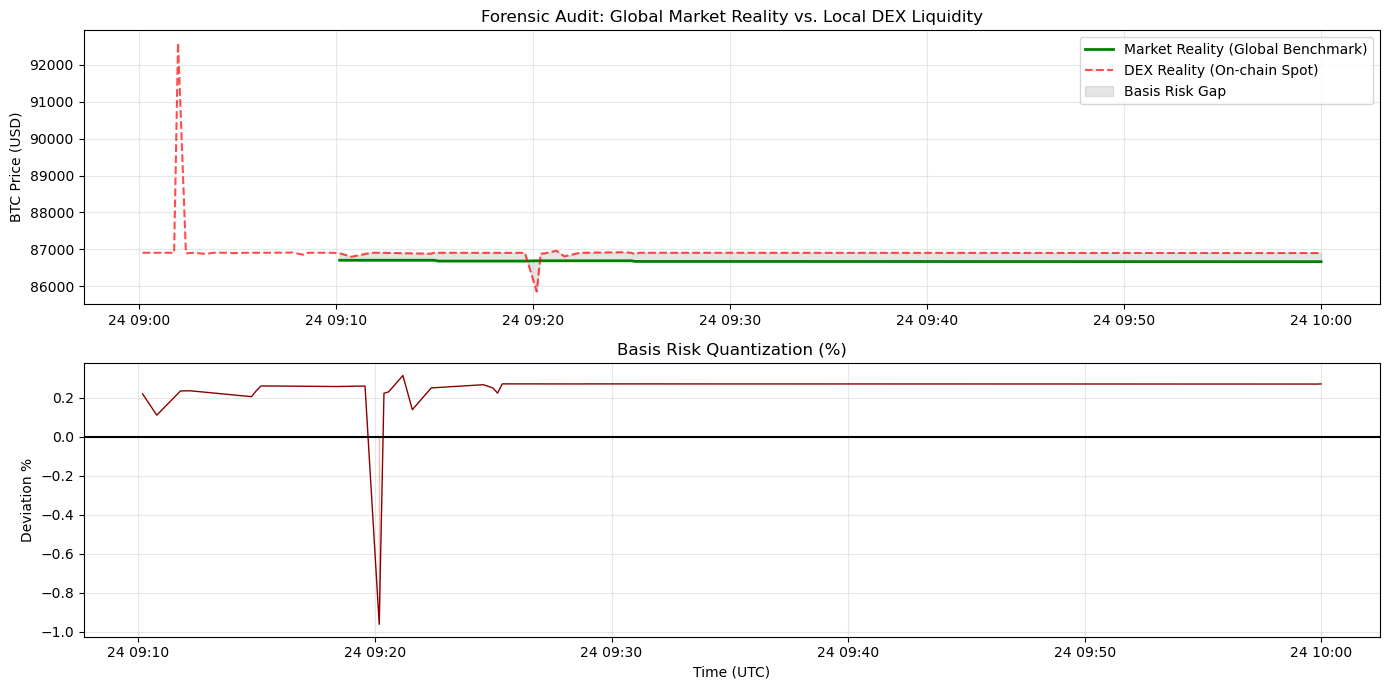

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Datasets ---
# 09 contains global benchmark prices (e.g., CEX aggregated)
# 03 contains on-chain DEX spot prices at block level
df_global = pd.read_csv('09_oracle_market_benchmarking.csv')
df_dex = pd.read_csv('03_deviation_audit.csv')

# --- 2. Pre-processing: Time Normalization ---
# Convert global timestamps
df_global['minute'] = pd.to_datetime(df_global['minute'], dayfirst=True)
df_global = df_global[df_global['symbol'] == 'WBTC'].sort_values('minute')

# Fix truncated block timestamps (MM:SS.f -> YYYY-MM-DD HH:MM:SS)
# Assuming the incident hour is 09:xx based on the benchmark data
def fix_block_time(ts_str):
    try:
        # Reconstruct as Dec 24, 2025, 09:MM:SS
        return pd.to_datetime(f"2025-12-24 09:{ts_str}")
    except:
        return pd.NaT

df_dex['timestamp_fixed'] = df_dex['Block timestamp'].apply(fix_block_time)
df_dex = df_dex.dropna(subset=['timestamp_fixed']).sort_values('timestamp_fixed')

# --- 3. Data Alignment ---
# We use 'asof' merge to align the block-level DEX data with the nearest minute-level Global data
# This allows us to compare the Spot price against the Global Market Reality at the same moment.
df_audit = pd.merge_asof(
    df_dex, 
    df_global[['minute', 'price']], 
    left_on='timestamp_fixed', 
    right_on='minute', 
    direction='backward'
)

df_audit.rename(columns={'price': 'Global_Benchmark_Price', 'Min price': 'DEX_Spot_Price'}, inplace=True)

# --- 4. Basis Risk Calculation ---
# Basis Risk = (DEX Spot - Global Benchmark) / Global Benchmark * 100
df_audit['Basis_Risk_Pct'] = (
    (df_audit['DEX_Spot_Price'] - df_audit['Global_Benchmark_Price']) / 
    df_audit['Global_Benchmark_Price'] * 100
)

# --- 5. Visualization: Market Reality vs. DEX Reality ---
plt.figure(figsize=(14, 7))

# Plot 1: Price Comparison
plt.subplot(2, 1, 1)
plt.plot(df_audit['timestamp_fixed'], df_audit['Global_Benchmark_Price'], 
         label='Market Reality (Global Benchmark)', color='green', linewidth=2)
plt.plot(df_audit['timestamp_fixed'], df_audit['DEX_Spot_Price'], 
         label='DEX Reality (On-chain Spot)', color='red', alpha=0.7, linestyle='--')

# Fill the "Basis Risk Gap"
plt.fill_between(df_audit['timestamp_fixed'], 
                 df_audit['Global_Benchmark_Price'], 
                 df_audit['DEX_Spot_Price'], 
                 color='gray', alpha=0.2, label='Basis Risk Gap')

plt.title('Forensic Audit: Global Market Reality vs. Local DEX Liquidity')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Basis Risk Percentage
plt.subplot(2, 1, 2)
plt.fill_between(df_audit['timestamp_fixed'], df_audit['Basis_Risk_Pct'], 0, 
                 where=(df_audit['Basis_Risk_Pct'] < 0), color='red', alpha=0.3)
plt.plot(df_audit['timestamp_fixed'], df_audit['Basis_Risk_Pct'], color='darkred', linewidth=1)

plt.axhline(y=0, color='black', linestyle='-')
plt.title('Basis Risk Quantization (%)')
plt.ylabel('Deviation %')
plt.xlabel('Time (UTC)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('market_reality_basis_risk.png')
plt.show()

# --- 6. Export Audit Results ---
df_audit[['Block number', 'timestamp_fixed', 'DEX_Spot_Price', 'Global_Benchmark_Price', 'Basis_Risk_Pct']].to_csv('Market_Forensic_Evidence.csv', index=False)